## Comprensión del negocio

## Comprensión de los datos

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [ ]:
file_path = "../dataset/raw/percolaciones.csv"

In [3]:
pd.read_csv(file_path, sep=";")

,FECHA,HRA,Cu [gpl],Ph
0,27-10-2024,10:00,NaN,NaN
1,NaN,13:00,NaN,NaN
2,NaN,16:00,"16,76","1,15"
3,NaN,19:00,"35,51","2,57"
4,NaN,22:00,"30,16","2,22"
...,...,...,...,...
520,13-01-2024,10:00,"0,19","1,56"
521,NaN,13:00,NaN,NaN
522,NaN,16:00,NaN,NaN
523,NaN,19:00,NaN,NaN


Al visualizar los 5 primeros y últimos registros del conjunto de datos:
* La primera fecha corresponde al 27 de octubre de 2024, lo que es erróneo, porque la fecha de inicio del proceso de medición debiera ser octubre del 2023.
* Hay valores nulos en la columna FECHA, porque la tabla del archivo Excel original está estructurada de tal manera que la fecha sólo se indica en la primera fila de cada serie temporal. La serie temporal corresponde al conjunto diario de registros.
* El separador decimal es una coma, por lo que habría que modificar su formato a punto, para su correcta manipulación.

In [4]:
df = pd.read_csv(file_path, sep=";")

In [5]:
df.columns = ["Date", "Time", "Cu", "pH"]

1) Llenar los valores nulos de la columna Date con la fecha correspondiente a cada serie de tiempo.
2) Reemplazar coma por punto en los separadores decimales de las columnas Cu y pH.

In [6]:
df_2 = df.copy()

In [7]:
# 1)
df_2["Date"] = df_2["Date"].ffill()

# 2)
df_2["Cu"] = df_2["Cu"].str.replace(',', '.', regex=False)
df_2["pH"] = df_2["pH"].str.replace(',', '.', regex=False)

Imprimir última fecha de registro de diciembre, para cambiar el año de la fecha desde el primer registro hasta el último de diciembre

In [8]:
df_2["Date"].where(df_2["Date"].str.contains("12-2024")).dropna().tail(1)

468    31-12-2024
Name: Date, dtype: object

Reemplazar el año 2024 por 2023 desde octubre a diciembre

In [9]:
for i in range(10, 13):
    df_2["Date"] = (
        df_2["Date"]
        .str
        .replace(f"{i}-2024", 
                 f"{i}-2023", 
                 regex=False)
    )

In [10]:
# Comprobación
df_2.head()

,Date,Time,Cu,pH
0,27-10-2023,10:00,NaN,NaN
1,27-10-2023,13:00,NaN,NaN
2,27-10-2023,16:00,16.76,1.15
3,27-10-2023,19:00,35.51,2.57
4,27-10-2023,22:00,30.16,2.22


In [11]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    525 non-null    object
 1   Time    525 non-null    object
 2   Cu      431 non-null    object
 3   pH      422 non-null    object
dtypes: object(4)
memory usage: 16.5+ KB


Cambios necesarios:
1) Cambiar tipo de dato en columnas Cu y pH a numérico.
2) Concatenar las columnas Date y Time, en una nueva columna Timestamp.
3) Cambiar tipo de dato en columna de tiempo.
4) Definir Timestamp como índice y eliminar las columnas Date y Time.

In [12]:
# 1)
df_2["Cu"] = pd.to_numeric(df_2["Cu"], errors="coerce")
df_2["pH"] = pd.to_numeric(df_2["pH"], errors="coerce")

# 2)
df_2["Timestamp"] = df_2["Date"] + " " + df["Time"]

# 3)
df_2["Timestamp"] = pd.to_datetime(df_2["Timestamp"], 
                                   format="%d-%m-%Y %H:%M", 
                                   errors="coerce")

# 4)
df_2 = df_2.set_index("Timestamp").drop(["Date", "Time"], axis=1)

### DataFrame consolidado

In [13]:
df_2

,Cu,pH
Timestamp,,
2023-10-27 10:00:00,NaN,NaN
2023-10-27 13:00:00,NaN,NaN
2023-10-27 16:00:00,16.76,1.15
2023-10-27 19:00:00,35.51,2.57
2023-10-27 22:00:00,30.16,2.22
...,...,...
2024-01-13 10:00:00,0.19,1.56
2024-01-13 13:00:00,NaN,NaN
2024-01-13 16:00:00,NaN,NaN


### Variables
* **Cu:** Gramos de cobre por litro de solución.
* **pH:** Nivel de pH en la solución.

In [14]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525 entries, 2023-10-27 10:00:00 to 2024-01-13 22:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Cu      427 non-null    float64
 1   pH      422 non-null    float64
dtypes: float64(2)
memory usage: 12.3 KB


In [15]:
df_2.describe()

,Cu,pH
count,427.000000,422.000000
mean,3.071991,1.799076
std,6.722241,0.307814
min,0.180000,0.500000
25%,0.520000,1.630000
50%,0.950000,1.735000
75%,1.840000,1.860000
max,38.020000,4.810000


In [16]:
df_2.corr()

,Cu,pH
Cu,1.000000,0.696612
pH,0.696612,1.000000


### Primeras observaciones
**Información general**
* 525 registros.
* Valores nulos:
    * Cu: 98 (18,6%)
    * pH: 103 (19,6%)

**Estadísticos**
* Desviación estándar:
    * La desviación estándar de ambas columnas indica que hay una mayor dispersión en la de Cu (6.72) que en la de pH (0.3).
* Correlación:
    * Un valor de 0.696612 está en el rango de 0.5 a 0.9, lo que generalmente se considera una correlación positiva fuerte. En otras palabras, la relación entre los gramos de cobre por litro y el pH es bastante significativa.
    * Sin embargo, esta correlación no implica causalidad. Aunque hay una relación entre las dos variables, no significa necesariamente que una cause el cambio en la otra.



#### Comparación de la varianza entre ambas variables
* Para comparar la varianza entre las variables Cu y pH, es necesario llevar ambas al mismo rango. 
* En este caso, se aplica normalización (Min-Max Scaling), para ajustar los valores en un rango de [0, 1].

In [17]:
df_2_clean = df_2[["Cu", "pH"]].dropna()

scaler_minmax = MinMaxScaler()
data_normalized = scaler_minmax.fit_transform(df_2_clean)

std_Cu, std_pH = data_normalized.std(axis=0).round(4)

print("std_Cu:", std_Cu)
print("std_pH:", std_pH)

std_Cu: 0.1799
std_pH: 0.0713


* Los resultados anteriores muestran que, aunque ambas variables se han normalizado al mismo rango, Cu sigue teniendo una variabilidad más alta que pH. Esto indica que, incluso después de la normalización, los valores de Cu tienden a disperarse más que los de pH en relación con su respectivo rango.

* Esto puede implicar que Cu tiene una mayor sensibilidad o respuesta a los factores que afectan su comportamiento en los datos. Por el contrario, la menor dispersión de pH sugiere que esta variable puede ser más estable o menos influenciada por variaciones extremas.

---

### Gráficos de dispersión e Histogramas
Para seguir estudiando la relación entre las dos variables

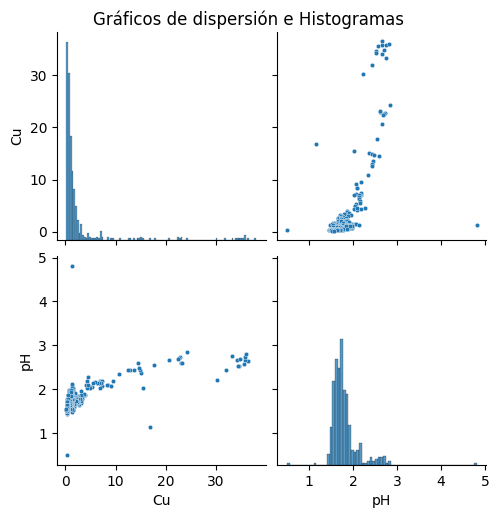

In [18]:
sns.pairplot(df_2, plot_kws={"s": 10}) 
plt.suptitle(f"Gráficos de dispersión e Histogramas", y=1.02)
plt.show()

In [19]:
columns = ["Cu", "pH"]
bins_names = ["cu_bins", "ph_bins"]
bins_values = {}

for col, bin_name in zip(columns, bins_names):
    clean_data = df_2[col].dropna()
    bins_values[bin_name] = int(np.ceil(np.log2(len(clean_data))) + 1)
    
cu_bins = bins_values["cu_bins"]
ph_bins = bins_values["ph_bins"]

for bin_name, bins in bins_values.items():
    print(f"N° bins {bin_name.replace("_bins", "")}:", bins)

N° bins cu: 10
N° bins ph: 10


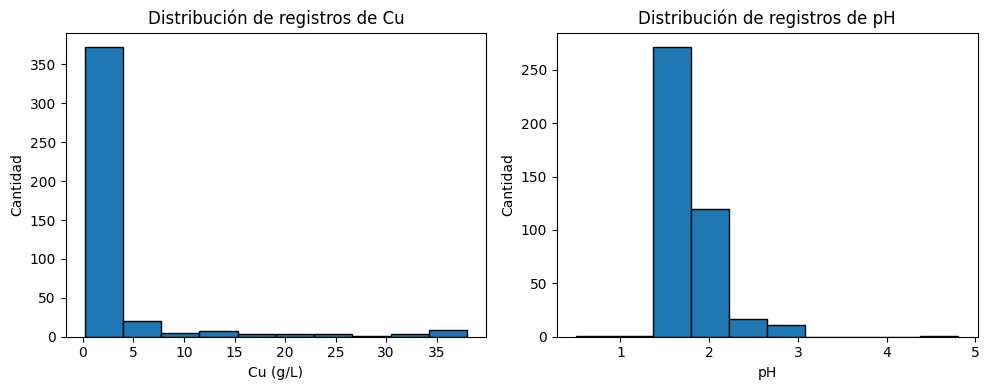

In [32]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(10, 4))

titles = ["Distribución de registros de Cu", 
          "Distribución de registros de pH"]
x_labels = ["Cu (g/L)", "pH"]
bins = [cu_bins, ph_bins]

for i, (column_name, 
        title, 
        x_label, 
        bin_count) in enumerate(zip(columns, 
                                    titles, 
                                    x_labels, 
                                    bins)):
    axes[i].set_title(title)
    axes[i].set_xlabel(x_label)
    axes[i].set_ylabel("Cantidad")
    axes[i].hist(df_2[column_name], 
                 bins=bin_count, 
                 edgecolor="black")

plt.tight_layout()
plt.show()

A partir de los gráficos, se puede determinar lo siguiente:

**Histograma**
* Cu (arriba-izquierda): La distribución está segada a la derecha, con una mayor concentración de valores en el rango más bajo (cercano a 0). Hay una gran cantidad de valores pequeños y un número decreciente de valoes más grandes.
* pH (abajo-derecha): La distribución también muestra un sesgo, pero menos pronunciado que el de Cu. Los valores de pH están mayormente concentrados entre 1 y 3.

**Gráficos de dispersión**
* Entre Cu y pH (arriba-derecha/abajo-izquierda): Hay una relación positiva entre ambas variables. A medida que los valores de pH aumentan, los de Cu también tienden a aumentar, y viceversa. Sin embargo, esta relación parece no ser lineal, con una mayor concentración de puntos en los valores vabajos de Cu y pH.

**Distribución conjunta**
* La distribución conjunta muestra que, aunque hay una tendencia general, la relación tiene una variabilidad considerable, especialmente en valores bajos de Cu, donde los valores de pH son más dispersos.

En resumen, los gráficos sugieren que, aunque existe una relación entre Cu y pH, ésta no es simple y podría requerir un análisis más profundo para entender completamente la dinámica entre estas dos variables. Además, la distribución sesgada de ambas variables indica que podría ser útil aplicar alguna transformación para analizar mejor los datos, como una transformación logarítmica.

---

### Boxplots
En los gráficos de dispersión anteriores se pueden observar algunos valores atípicos, por lo que se procede a generar un gráfico de cajas para identificarlos y hacerlos más visibles.

#### Cu

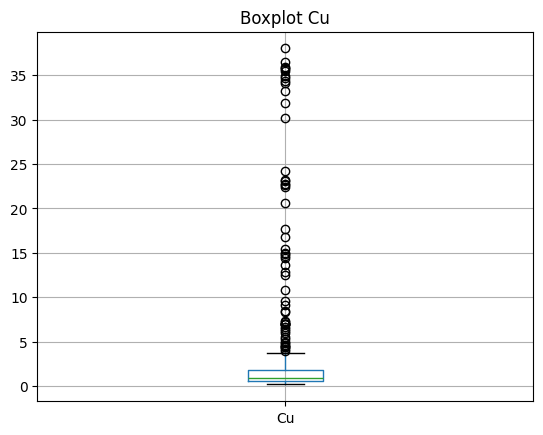

In [20]:
plt.title("Boxplot Cu")
df_2.boxplot(column="Cu")
plt.show()

En el boxplot de Cu se pueden observar únicamente outliers superiores, ya que la mediana está muy cerca del valor 0.

#### pH

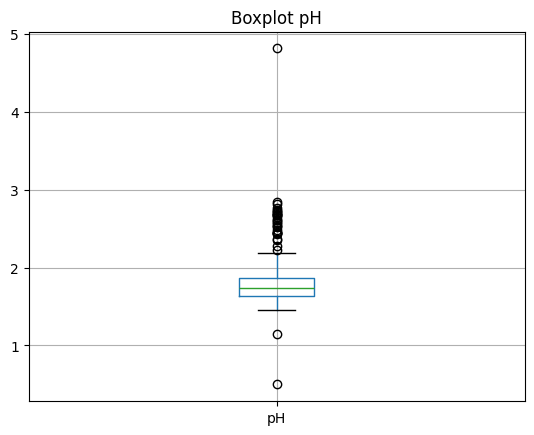

In [21]:
plt.title("Boxplot pH")
df_2.boxplot(column="pH")
plt.show()

En cambio, en el boxplot de pH hay outliers bajo y sobre la mediana, habiendo una concentración mayor cerca del ámbito de la caja y uno solo entre 4 y 5.

## Descargar datasets
Para uso en otros archivos

In [ ]:
df_2.to_csv("../dataset/processed/solution_data.csv")